In [3]:
import requests
from requests.auth import HTTPBasicAuth
import json

# Load Kaggle credentials
with open("kaggle.json") as f:
    kaggle_creds = json.load(f)

username = kaggle_creds["username"]
key = kaggle_creds["key"]

dataset = "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
url = f"https://www.kaggle.com/api/v1/datasets/download/{dataset}"

print("Downloading dataset...")

response = requests.get(url, auth=HTTPBasicAuth(username, key), stream=True)

with open("gtsrb.zip", "wb") as f:
    for chunk in response.iter_content(1024):
        f.write(chunk)

print("Download complete!")


Download complete!


In [4]:
import zipfile

with zipfile.ZipFile("gtsrb.zip", 'r') as zip_ref:
    zip_ref.extractall("gtsrb_data")

print("Extracted to gtsrb_data/")


Extracted to gtsrb_data/


Random image path:gtsrb_data/Train/39/00039_00008_00022.png
ranodm image height:53
ranodm image width:54
ranodm image class:39


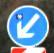

In [5]:
import os
from  pathlib import Path
from PIL import Image
import random

data_path=Path("gtsrb_data")

random.seed(42)
image_path_list=list(data_path.rglob("*.png"))
random_image=random.choice(image_path_list)
img_class=random_image.parent.stem
img=Image.open(random_image)
print(f"Random image path:{random_image}")
print(f"ranodm image height:{img.height}")
print(f"ranodm image width:{img.width}")
print(f"ranodm image class:{img_class}")
img


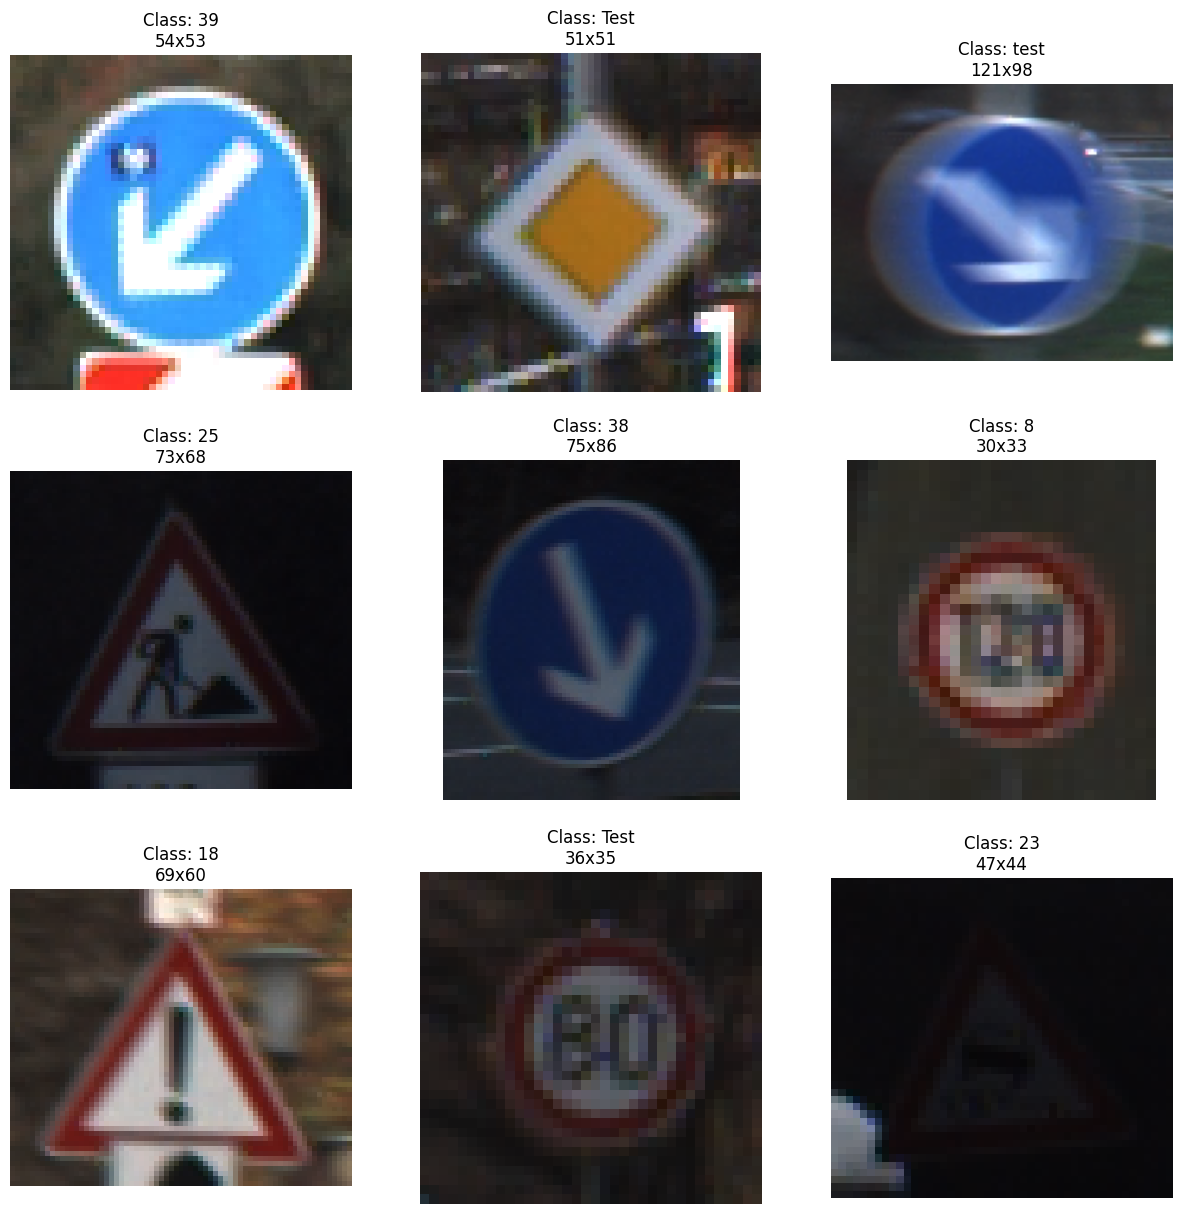

In [6]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

random.seed(42)

data_path = Path("gtsrb_data")
image_path_list = list(data_path.rglob("*.png"))

random_images = random.sample(image_path_list, k=9)

plt.figure(figsize=(15, 15))

for i, image_path in enumerate(random_images):
    img = Image.open(image_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")

    image_class = image_path.parent.stem

    plt.title(f"Class: {image_class}\n{img.width}x{img.height}")

plt.show()


In [7]:
import os
def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [8]:
walk_through_dir(data_path)

There are 6 directories and 3 images in 'gtsrb_data'.
There are 43 directories and 0 images in 'gtsrb_data/train'.
There are 0 directories and 240 images in 'gtsrb_data/train/42'.
There are 0 directories and 1110 images in 'gtsrb_data/train/17'.
There are 0 directories and 600 images in 'gtsrb_data/train/26'.
There are 0 directories and 1200 images in 'gtsrb_data/train/35'.
There are 0 directories and 689 images in 'gtsrb_data/train/33'.
There are 0 directories and 1200 images in 'gtsrb_data/train/18'.
There are 0 directories and 1440 images in 'gtsrb_data/train/7'.
There are 0 directories and 1410 images in 'gtsrb_data/train/8'.
There are 0 directories and 780 images in 'gtsrb_data/train/31'.
There are 0 directories and 420 images in 'gtsrb_data/train/16'.
There are 0 directories and 1470 images in 'gtsrb_data/train/9'.
There are 0 directories and 2070 images in 'gtsrb_data/train/38'.
There are 0 directories and 2220 images in 'gtsrb_data/train/1'.
There are 0 directories and 2010 ima

In [9]:
import torch
from torchvision import transforms

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [11]:
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [12]:
train_dir=data_path/"Train"
test_dir=data_path/"Test"

In [13]:
from typing import Tuple,Dict,List

In [14]:
def find_classes(directory:str)->Tuple[list[str],Dict[str,int]]:
  classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
      raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  class_to_idx={cls_name:i for i,cls_name in enumerate(classes)}
  return classes,class_to_idx

In [15]:
from torch.utils.data import Dataset
import pathlib
class ImageFolderCustom(Dataset):
  def __init__(self,target_dir:str,transform=None)->None:
    self.paths=list(pathlib.Path(target_dir).glob('*/*.png'))
    self.transform=transform
    self.classes,self.class_to_idx=find_classes(target_dir)
  def load_image(self,index:int)->Image.Image:
    image_path=self.paths[index]
    return Image.open(image_path)
  def __len__(self)->int:
    return len(self.paths)
  def __getitem__(self,index:int)->Tuple[torch.Tensor,int]:
    img=self.load_image(index)
    class_name=self.paths[index].parent.name
    class_idx=self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img),class_idx

    else:
      return img,class_idx


In [16]:

train_dataset=ImageFolderCustom(train_dir,transform=train_transforms)


In [17]:
import pandas as pd


In [18]:
class GTSRBTestDataset(Dataset):
    def __init__(self, image_dir, csv_file, class_to_idx, transform=None):
        self.image_dir = pathlib.Path(image_dir)
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      img_rel_path = self.data.iloc[idx]["Path"]

      if img_rel_path.startswith("Test/"):
          img_rel_path = img_rel_path.replace("Test/", "", 1)

      img_path = self.image_dir / img_rel_path
      img = Image.open(img_path).convert("RGB")

      # 🔑 CORRECT label mapping
      class_id = str(self.data.iloc[idx]["ClassId"])
      label = self.class_to_idx[class_id]

      if self.transform:
          img = self.transform(img)

      return img, label


In [19]:
test_dataset = GTSRBTestDataset(
    image_dir="gtsrb_data/Test",
    csv_file="gtsrb_data/Test.csv",
    class_to_idx=train_dataset.class_to_idx,
    transform=test_transforms
)


In [20]:
from torch.utils.data import DataLoader
import os

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [21]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units*2, 3, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.Conv2d(hidden_units*2, hidden_units*2, 3, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*2 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)


In [22]:
model=TinyVGG(input_shape=3,
              hidden_units=32,
              output_shape=43)

In [23]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
model.to(device)

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(sta

In [25]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)


In [26]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    train_loss, train_acc = 0.0, 0.0
    model.train()

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_label = y_pred.argmax(dim=1)
        train_acc += (y_pred_label == y).sum().item() / len(y)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc
def test_step(model, dataloader, loss_fn, device):
    test_loss, test_acc = 0.0, 0.0
    model.eval()

    with torch.inference_mode():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            test_pred = model(x)
            loss = loss_fn(test_pred, y)

            test_loss += loss.item()

            test_pred_label = test_pred.argmax(dim=1)
            test_acc += (test_pred_label == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


In [27]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model, train_dataloader, loss_fn, optimizer, device
        )

        test_loss, test_acc = test_step(
            model, test_dataloader, loss_fn, device
        )

        print(
            f"Epoch: {epoch+1} | "
            f"Train loss: {train_loss:.4f} | "
            f"Train acc: {train_acc:.4f} | "
            f"Test loss: {test_loss:.4f} | "
            f"Test acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [28]:
from timeit import default_timer as timer
start_time=timer()
results=train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=10,
      device=device)
end_time=timer()
print(f"Training time:{end_time-start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 3.1485 | Train acc: 0.1208 | Test loss: 2.4910 | Test acc: 0.2840
Epoch: 2 | Train loss: 2.7458 | Train acc: 0.1945 | Test loss: 1.9928 | Test acc: 0.3795
Epoch: 3 | Train loss: 2.4862 | Train acc: 0.2384 | Test loss: 1.7662 | Test acc: 0.3997
Epoch: 4 | Train loss: 2.2829 | Train acc: 0.2835 | Test loss: 1.6686 | Test acc: 0.4245
Epoch: 5 | Train loss: 2.1354 | Train acc: 0.3214 | Test loss: 1.5004 | Test acc: 0.5507
Epoch: 6 | Train loss: 2.0176 | Train acc: 0.3488 | Test loss: 1.3351 | Test acc: 0.5800
Epoch: 7 | Train loss: 1.8196 | Train acc: 0.4110 | Test loss: 1.1446 | Test acc: 0.6568
Epoch: 8 | Train loss: 1.6643 | Train acc: 0.4633 | Test loss: 0.9235 | Test acc: 0.7528
Epoch: 9 | Train loss: 1.4897 | Train acc: 0.5092 | Test loss: 0.7210 | Test acc: 0.7899
Epoch: 10 | Train loss: 1.3132 | Train acc: 0.5660 | Test loss: 0.5871 | Test acc: 0.8533
Training time:669.3062677139999


In [29]:
import pandas as pd
results=pd.DataFrame(results)
results

,train_loss,train_acc,test_loss,test_acc
0,3.148467,0.120818,2.490966,0.283997
1,2.745756,0.194461,1.992751,0.379488
2,2.486176,0.238372,1.766220,0.399662
3,2.282937,0.283481,1.668552,0.424504
4,2.135446,0.321374,1.500414,0.550712
5,2.017588,0.348812,1.335144,0.580027
6,1.819624,0.410955,1.144577,0.656753
7,1.664273,0.463331,0.923454,0.752834
8,1.489716,0.509231,0.721022,0.789895
9,1.313154,0.565993,0.587122,0.853344


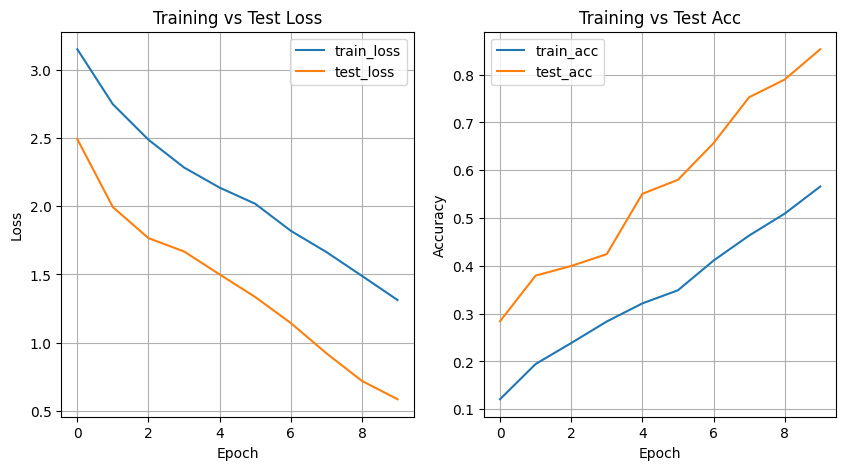

In [30]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(results["train_loss"],label="train_loss")
plt.plot(results["test_loss"],label="test_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results["train_acc"],label="train_acc")
plt.plot(results["test_acc"],label="test_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Acc")
plt.legend()
plt.grid(True)




In [68]:
from typing import List, Tuple
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (64, 64),
    transform: torchvision.transforms = None,
    device: torch.device = torch.device("cpu")
):
    # 1. Load image
    img = Image.open(image_path).convert("RGB")

    # 2. Create transform if none provided
    if transform is None:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
            )
        ])
    else:
        image_transform = transform

    # 3. Prepare model
    model = model.to(device)
    model.eval()

    # 4. Inference
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(0).to(device)
        logits = model(transformed_image)
        probs = torch.softmax(logits, dim=1)
        pred_label = probs.argmax(dim=1).item()
        pred_prob = probs.max().item()

    # 5. Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_prob:.3f}")
    plt.axis("off")
    plt.show()


In [69]:
def give_class_names(image_path:str)->List[str]:
  class_names=sorted(entry.name for entry in os.scandir(image_path) if entry.is_dir())
  return class_names


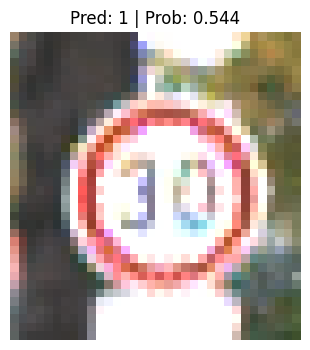

In [74]:
from pathlib import Path
import random

# class names ALWAYS from Train
class_names = give_class_names("gtsrb_data/Train")

# pick random image from Test
test_images = list(Path("gtsrb_data/Test").glob("*.png"))
random_test_image = random.choice(test_images)

# predict
pred_and_plot_image(
    model=model,
    image_path=str(random_test_image),
    class_names=class_names,
    transform=test_transforms,
    device=device
)


PosixPath('gtsrb_data/test')

In [75]:
import torch
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [76]:
test_df = pd.read_csv("gtsrb_data/Test.csv")


In [78]:
from PIL import Image
import torch
from pathlib import Path
import pandas as pd

test_df = pd.read_csv("gtsrb_data/Test.csv")

y_true = []
y_pred = []

dataset_root = Path("gtsrb_data")

model.eval()

for _, row in test_df.iterrows():
    img_path = dataset_root / row["Path"]   # ✅ FIX
    true_label = row["ClassId"]

    img = Image.open(img_path).convert("RGB")
    x = test_transforms(img).unsqueeze(0).to(device)

    with torch.inference_mode():
        logits = model(x)
        pred_label = logits.argmax(dim=1).item()

    y_true.append(true_label)
    y_pred.append(pred_label)


In [79]:
cm = confusion_matrix(y_true, y_pred)
print(cm.shape)


(43, 43)


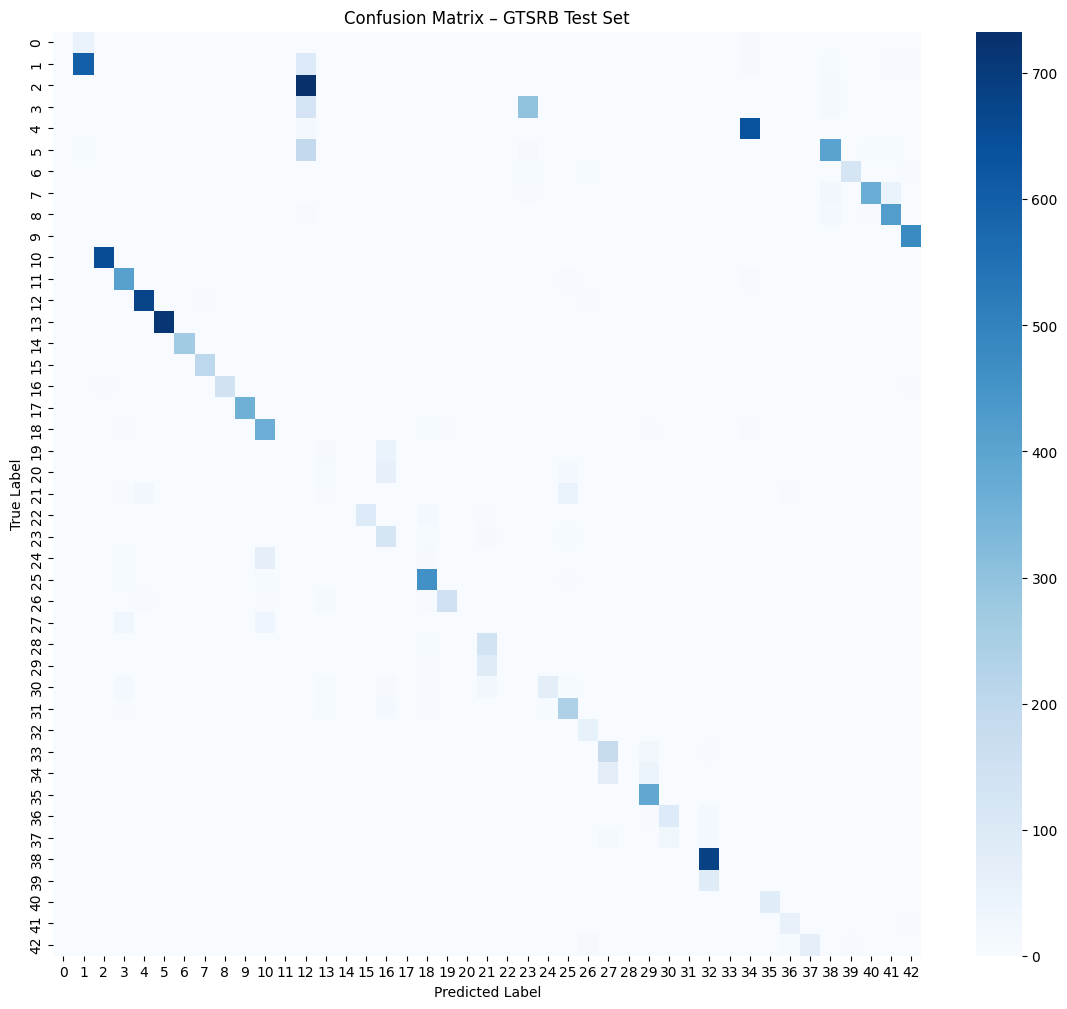

In [84]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – GTSRB Test Set")
plt.show()
